# Density Estimation for a mixture of Gaussians (using GaussianMixtures.jl)

Adapted from http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html

Plot the density estimation of a mixture of two Gaussians. Data is generated from two Gaussians with different centers and covariance matrices.

In [1]:
using PyPlot, PyCall
using ScikitLearn
using ScikitLearn.Utils: meshgrid

@pyimport matplotlib.colors as mpl_colors

In [38]:
using GaussianMixtures
import GaussianMixtures: GMM, logsumexp, llpg, kind

# We set d=1, but that's OK, we'll change it in fit!
GMM(; n=1, kind=:diag) = GMM(n, 2; kind=kind)
is_classifier(::GMM) = true

function reinitialize!(gmm::GMM, n, d)
    # Taken from the GMM(n, d) constructor
    if kind(gmm) == :diag
        gmm.Σ = ones(n, d)
    elseif kind(gmm) == :full
        gmm.Σ = UpperTriangular{Float64, Matrix{Float64}}[UpperTriangular(eye(d)) for i=1:n]
    else
        error("Unknown kind")
    end
    rng = MersenneTwister(42)
    #gmm.μ = rand(rng, n, d)
    gmm.hist = [History(@sprintf "Initialization n=%d, d=%d, kind=%s" n d kind)]
end

function Base.copy!(gmm_dest::GMM, gmm_src::GMM)
    # shallow copy
    for f in fieldnames(gmm_dest)
        setfield!(gmm_dest, f, getfield(gmm_src, f))
    end
end

function fit_bad!(gmm::GMM, X)
    # Now that we know d, reinitialize the matrices
    reinitialize!(gmm, size(gmm.μ, 1), size(X, 2))
    em!(gmm, X)
    gmm
end 

function fit!(gmm::GMM, X::AbstractMatrix)
    n = size(gmm.μ, 1)
    # Creating a temporary is not great, but it's negligible in the grand scheme of thing.
    # We'd just need a slight refactor in GaussianMixtures/src/train.jl to avoid it
    gmm_temp = GMM(n, X; kind=kind(gmm))
    copy!(gmm, gmm_temp)
    gmm
end

predict_log_proba(gmm::GMM, X) = llpg(gmm::GMM, x::Matrix)
predict_proba(gmm::GMM, X) = exp(predict_log_proba(gmm, X))

density(gmm::GMM, X) = squeeze(logsumexp(broadcast(+, llpg(gmm, X), reshape(log(gmm.w), 1, length(gmm.w))), 2), 2)

# score_samples is underspecified by the scikit-learn API, so we're more or less free to return what we want
# http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GMM.html#sklearn.mixture.GMM
# http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html
"""    score_samples(gmm::GMM, X::Matrix)
Return the per-sample likelihood of the data under the model. """
score_samples(gmm::GMM, X) = density(gmm, X)

In [2]:
using Requires

In [3]:
@require GaussianMixtures println("yoyo")

2-element Array{Function,1}:
 (anonymous function)
 (anonymous function)

In [4]:
using GaussianMixtures: GMM

LoadError: error in method definition: function ScikitLearnBase.is_classifier must be explicitly imported to be extended
while loading /Users/cedric/.julia/v0.4/ScikitLearn/src/models/GaussianProcesses.jl, in expression starting on line 6


yoyo


In [3]:
n_samples = 300

# generate random sample, two components
srand(42)

# generate spherical data centered on (20, 20)
shifted_gaussian = randn(n_samples, 2) .+ [20, 20]'

# generate zero centered stretched Gaussian data
C = [0. -0.7
     3.5 .7]
stretched_gaussian = randn(n_samples, 2) * C

# concatenate the two datasets into the final training set
X_train = vcat(shifted_gaussian, stretched_gaussian)

# fit a Gaussian Mixture Model with two components
clf = GMM(n=2, kind=:full)

LoadError: LoadError: MethodError: `call` has no method matching call(::Type{GaussianMixtures.GMM{T<:AbstractFloat,CT<:Union{Array{T,1},Array{T,2}}}})
Closest candidates are:
  BoundsError()
  BoundsError(, !Matched::Any...)
  DivideError()
  ...
while loading In[3], in expression starting on line 18

In [45]:
fit!(clf, X_train)

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       7.850874e+03
      1       5.165666e+03      -2.685208e+03 |        0
      2       5.165666e+03       0.000000e+00 |        0
K-means converged with 2 iterations (objv = 5165.666163455702)


INFO: Initializing GMM, 2 Gaussians diag covariance 2 dimensions using 600 data points
INFO: K-means with 600 data points using 2 iterations
100.0 data points per parameter
INFO: Running 10 iterations EM on full cov GMM with 2 Gaussians in 2 dimensions
INFO: iteration 1, average log likelihood -2.026541
INFO: iteration 2, average log likelihood -2.026538
INFO: iteration 3, average log likelihood -2.026538
INFO: iteration 4, average log likelihood -2.026538
INFO: iteration 5, average log likelihood -2.026538
INFO: iteration 6, average log likelihood -2.026538
INFO: iteration 7, average log likelihood -2.026538
INFO: iteration 8, average log likelihood -2.026538
INFO: iteration 9, average log likelihood -2.026538
INFO: iteration 10, average log likelihood -2.026538
INFO: EM with 600 data points 10 iterations avll -2.026538
54.5 data points per parameter


GMM{Float64} with 2 components in 2 dimensions and full covariance
Mix 1: weight 0.500000
mean: 1x2 Array{Float64,2}:
 -0.298301  -0.00712635
covariance: 2x2 Array{Float64,2}:
 13.964    2.89262
  2.89262  1.09462
Mix 2: weight 0.500000
mean: 1x2 Array{Float64,2}:
 19.9828  19.9162
covariance: 2x2 Array{Float64,2}:
  1.08001    -0.0117825
 -0.0117825   1.08029  


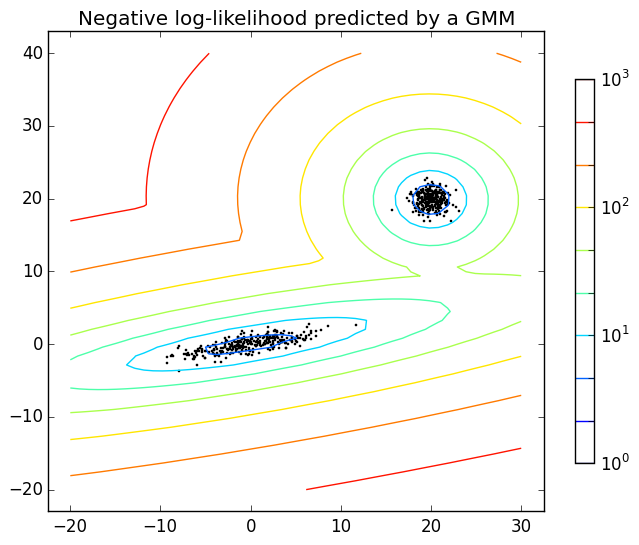

In [46]:
# display predicted scores by the model as a contour plot
x = linspace(-20.0, 30.0)
y = linspace(-20.0, 40.0)
X, Y = meshgrid(x, y)
XX = hcat(X[:], Y[:])
Z = -score_samples(clf, XX)

Z = reshape(Z, size(X))

CS = contour(X, Y, Z, norm=mpl_colors.LogNorm(vmin=1.0, vmax=1000.0),
             levels=logspace(0, 3, 10))
CB = colorbar(CS, shrink=0.8, extend="both")
scatter(X_train[:, 1], X_train[:, 2], .8)

title("Negative log-likelihood predicted by a GMM")
axis("tight");